# Thực hành về mạng GAN

In [1]:
# !nvidia-smi
# from google.colab import drive
# drive.mount('/content/drive')

### Chuẩn bị các thư viện cần thiết

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import glob
import cv2
import torch.nn.functional as F
from torch.autograd import Variable

import torchvision
import torchvision.transforms as transforms

from torch.nn import CrossEntropyLoss, Dropout, Softmax, Linear, Conv2d, LayerNorm
import matplotlib.pyplot as plt
from torchsummary import summary

### Thiết lập các hằng số cho tập MNIST

In [3]:
width    = 28
height   = 28
channels = 1
epochs   = 1000

img_shape = (width, height, channels)

<H2>1. Tải tập dữ liệu MNIST</H2>

Ta chỉ dùng tập huấn luyện, không dùng nhãn. Các điểm ảnh được chuẩn hoá về miền giá trị [-1, 1] 

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5), (0.5))])

batch_size = 32

trainset = torchvision.datasets.MNIST(root = './data', train = True,
                                        download = True, transform = transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size = batch_size,
                                          shuffle = True, num_workers = 2)

Trực quan dữ liệu MNIST

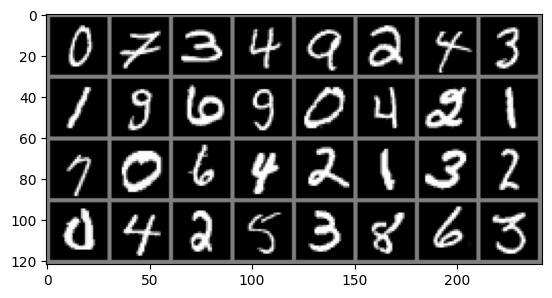

    0     7     3     4     9     2     4     3     1     9     6     9     0     4     2     1     7     0     6     4     2     1     3     2     0     4     2     5     3     8     6     3


In [5]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % labels[j].item() for j in range(batch_size)))

<H2>2. Generator</H2>
Lập trình kiến trúc Generator theo mô tả phía dưới

In [ ]:
""" Declare GENERATOR. 
    + Its input is a 100-feature vector of random noise
    + Its output is a fake image with pixel values in [-1, 1]"""

class Generator(nn.Module):
    def __init__(self):
      super(Generator, self).__init__()
      self.model = nn.Sequential(
        nn.Linear(100, 256),
        nn.LeakyReLU(0.25),
        nn.BatchNorm1d(256, momentum = 0.8),

        nn.Linear(256, 512),
        nn.LeakyReLU(0.2),
        nn.BatchNorm1d(512, momentum = 0.8),

        nn.Linear(512, 1024),
        nn.LeakyReLU(0.2),
        nn.BatchNorm1d(1024, momentum = 0.8),

        nn.Linear(1024, width  * height * channels),
        nn.Tanh(),
    )

    def forward(self, x):
        x = self.model(x)
        return x.view(-1, width, height, channels)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
G = Generator().to(device)
summary(G, (100, ), batch_size = -1, device = 'cuda')
print("_____________________ Generator Created_____________________")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 256]          25,856
         LeakyReLU-2                  [-1, 256]               0
       BatchNorm1d-3                  [-1, 256]             512
            Linear-4                  [-1, 512]         131,584
         LeakyReLU-5                  [-1, 512]               0
       BatchNorm1d-6                  [-1, 512]           1,024
            Linear-7                 [-1, 1024]         525,312
         LeakyReLU-8                 [-1, 1024]               0
       BatchNorm1d-9                 [-1, 1024]           2,048
           Linear-10                  [-1, 784]         803,600
             Tanh-11                  [-1, 784]               0
Total params: 1,489,936
Trainable params: 1,489,936
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forw

<H2>3. Discriminator</H2>
Lập trình kiến trúc Discriminator

In [ ]:
""" Declare DISCRIMINATOR 
    + Its input is REAL IMAGE (in a form of a vector 28x28)
    + Its ouput is the probability of image type (REAL IMAGE or FAKE IMAGE)
    the values in the range of [0, 1]"""

class Discriminator(nn.Module):
    def __init__(self):
      super(Discriminator, self).__init__()
      self.model = nn.Sequential(
        nn.Flatten(), 
        nn.Linear(width * height * channels, width * height * channels),
        nn.LeakyReLU(0.2),
        nn.Linear( width * height * channels, (width * height * channels) // 2),
        nn.LeakyReLU(0.2),
        nn.Linear((width * height * channels) // 2, 1),
        nn.Sigmoid(),
    )

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.model(x)

        return x

D = Discriminator().to(device)
summary(D, img_shape, batch_size = -1, device = 'cuda')
print("____________________ Discriminator Created____________________")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 784]         615,440
         LeakyReLU-3                  [-1, 784]               0
            Linear-4                  [-1, 392]         307,720
         LeakyReLU-5                  [-1, 392]               0
            Linear-6                    [-1, 1]             393
           Sigmoid-7                    [-1, 1]               0
Total params: 923,553
Trainable params: 923,553
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 3.52
Estimated Total Size (MB): 3.55
----------------------------------------------------------------
____________________ Discriminator Created____________________


<h2>4. Generative model</h2>

Xây dựng GAN và huấn luyện

In [ ]:
optimizer_G = optim.Adam(G.parameters(), lr = 0.0002, betas = (0.5, 0.999), weight_decay = 8e-8)
optimizer_D = optim.Adam(D.parameters(), lr = 0.0002, betas = (0.5, 0.999), weight_decay = 8e-8)

epochs        = 1000
adversarial_loss = nn.BCELoss().cuda()

losses_G = []
losses_D = []
samples = []

In [9]:
for epoch in range(epochs):
    for (i, (imgs, _)) in enumerate(trainloader, start=1):
        # Adversarial ground truths
        valid = torch.ones((imgs.size(0), 1), device = device, requires_grad = False)
        fake = torch.zeros((imgs.size(0), 1), device = device, requires_grad = False)

        # Configure input
        real_imgs = imgs.to(device).float()

        # -----------------
        #  Train Generator
        # -----------------
        optimizer_G.zero_grad()

        # Sample noise as generator input
        z = torch.randn((imgs.shape[0], 100), device=device)

        # Generate a batch of images
        gen_imgs = G(z)

        # Loss measures generator's ability to fool the discriminator
        g_loss = adversarial_loss(D(gen_imgs), valid)

        g_loss.backward()
        optimizer_G.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------
        optimizer_D.zero_grad()

        # Measure discriminator's ability to classify real from generated samples
        real_loss = adversarial_loss(D(real_imgs), valid)
        fake_loss = adversarial_loss(D(gen_imgs.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()

        if epoch % 10 == 0 and i == len(trainloader):
            print(
                "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"
                % (epoch, epochs, i, len(trainloader), d_loss.item(), g_loss.item())
            )

            losses_G.append(g_loss.item())
            losses_D.append(d_loss.item())
            samples.append(gen_imgs.detach().cpu())

[Epoch 0/1000] [Batch 1875/1875] [D loss: 0.518969] [G loss: 1.381205]
[Epoch 10/1000] [Batch 1875/1875] [D loss: 0.660298] [G loss: 1.330066]
[Epoch 20/1000] [Batch 1875/1875] [D loss: 0.572771] [G loss: 1.092411]
[Epoch 30/1000] [Batch 1875/1875] [D loss: 0.538851] [G loss: 1.549816]
[Epoch 40/1000] [Batch 1875/1875] [D loss: 0.547579] [G loss: 1.248690]
[Epoch 50/1000] [Batch 1875/1875] [D loss: 0.488962] [G loss: 1.667139]
[Epoch 60/1000] [Batch 1875/1875] [D loss: 0.431094] [G loss: 1.556290]
[Epoch 70/1000] [Batch 1875/1875] [D loss: 0.458344] [G loss: 1.383278]
[Epoch 80/1000] [Batch 1875/1875] [D loss: 0.527456] [G loss: 1.567330]
[Epoch 90/1000] [Batch 1875/1875] [D loss: 0.361098] [G loss: 2.071457]
[Epoch 100/1000] [Batch 1875/1875] [D loss: 0.418151] [G loss: 1.399327]
[Epoch 110/1000] [Batch 1875/1875] [D loss: 0.428605] [G loss: 0.872253]
[Epoch 120/1000] [Batch 1875/1875] [D loss: 0.450906] [G loss: 2.493449]
[Epoch 130/1000] [Batch 1875/1875] [D loss: 0.336127] [G loss:

### Vẽ đồ thị hàm loss huấn luyện

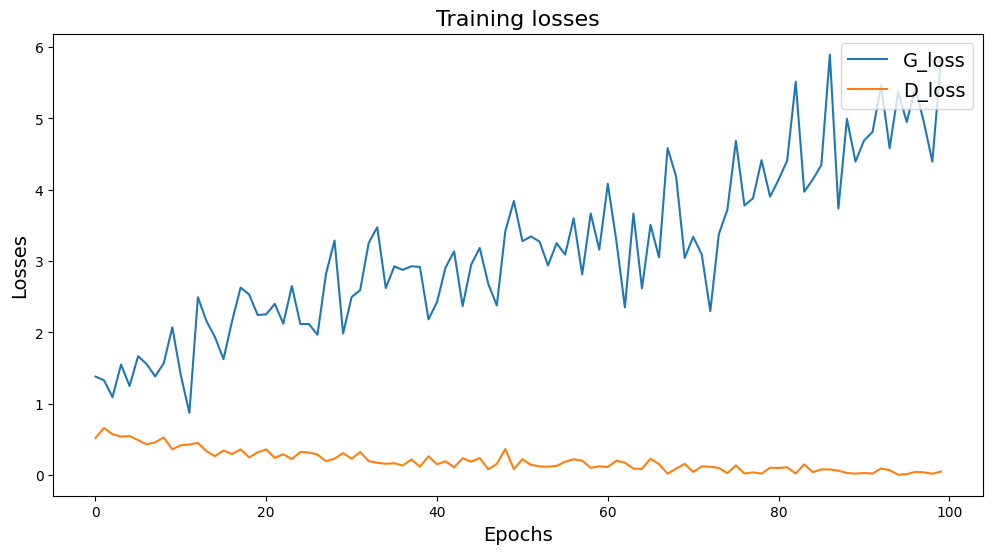

In [11]:
plt.figure(figsize = (12, 6))
plt.plot(list(range(int(len(losses_G) / 10) * 10)), losses_G, label = "G_loss")
plt.plot(list(range(int(len(losses_D) / 10) * 10)), losses_D, label = "D_loss")
plt.title("Training losses", fontsize = 16)
plt.xlabel("Epochs", fontsize = 14)
plt.ylabel("Losses", fontsize = 14)
plt.legend(loc = "upper right", fontsize = 14)
plt.show()

### Trực quan hoá kết quả sinh dữ liệu của mô hình đã huấn luyện

    ____________________ Step = 0 ____________________    ____________________ Step = 0 ____________________    ____________________ Step = 0 ____________________    ____________________ Step = 0 ____________________    ____________________ Step = 0 ____________________    ____________________ Step = 0 ____________________    ____________________ Step = 0 ____________________    ____________________ Step = 0 ____________________    ____________________ Step = 0 ____________________    ____________________ Step = 0 ____________________


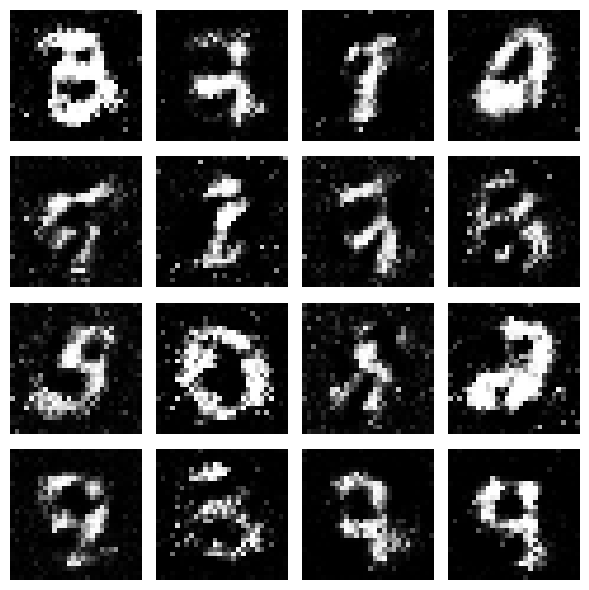



    ____________________ Step = 10 ____________________    ____________________ Step = 10 ____________________    ____________________ Step = 10 ____________________    ____________________ Step = 10 ____________________    ____________________ Step = 10 ____________________    ____________________ Step = 10 ____________________    ____________________ Step = 10 ____________________    ____________________ Step = 10 ____________________    ____________________ Step = 10 ____________________    ____________________ Step = 10 ____________________


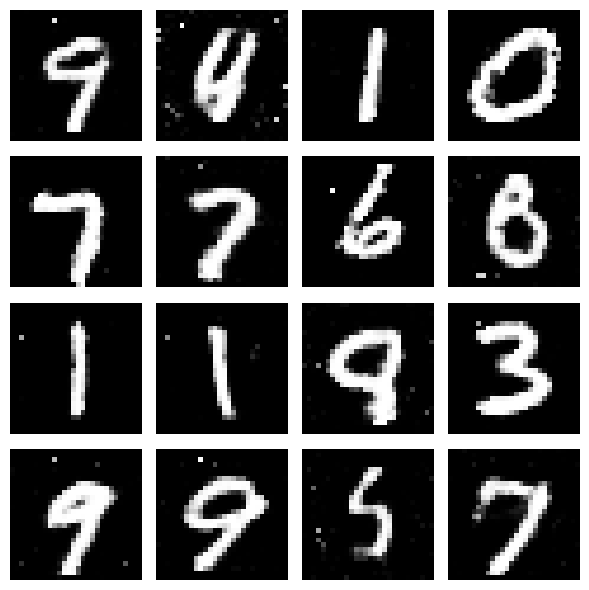



    ____________________ Step = 20 ____________________    ____________________ Step = 20 ____________________    ____________________ Step = 20 ____________________    ____________________ Step = 20 ____________________    ____________________ Step = 20 ____________________    ____________________ Step = 20 ____________________    ____________________ Step = 20 ____________________    ____________________ Step = 20 ____________________    ____________________ Step = 20 ____________________    ____________________ Step = 20 ____________________


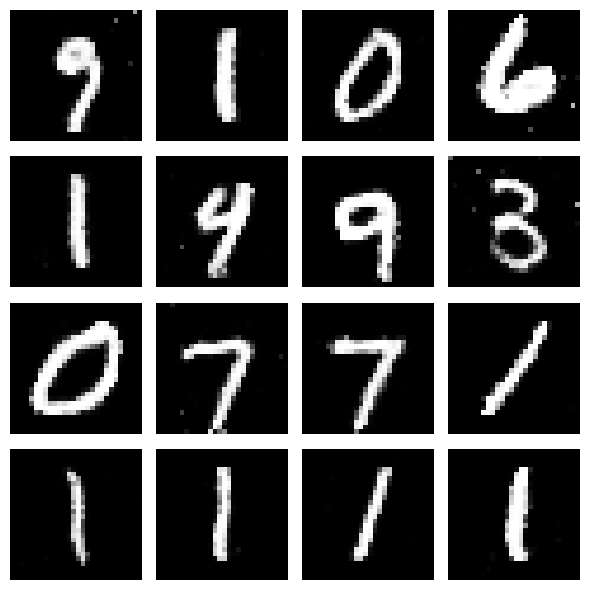



    ____________________ Step = 30 ____________________    ____________________ Step = 30 ____________________    ____________________ Step = 30 ____________________    ____________________ Step = 30 ____________________    ____________________ Step = 30 ____________________    ____________________ Step = 30 ____________________    ____________________ Step = 30 ____________________    ____________________ Step = 30 ____________________    ____________________ Step = 30 ____________________    ____________________ Step = 30 ____________________


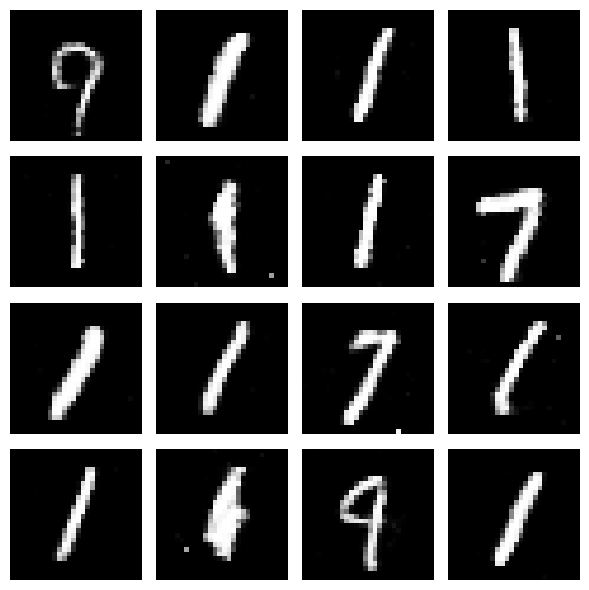



    ____________________ Step = 40 ____________________    ____________________ Step = 40 ____________________    ____________________ Step = 40 ____________________    ____________________ Step = 40 ____________________    ____________________ Step = 40 ____________________    ____________________ Step = 40 ____________________    ____________________ Step = 40 ____________________    ____________________ Step = 40 ____________________    ____________________ Step = 40 ____________________    ____________________ Step = 40 ____________________


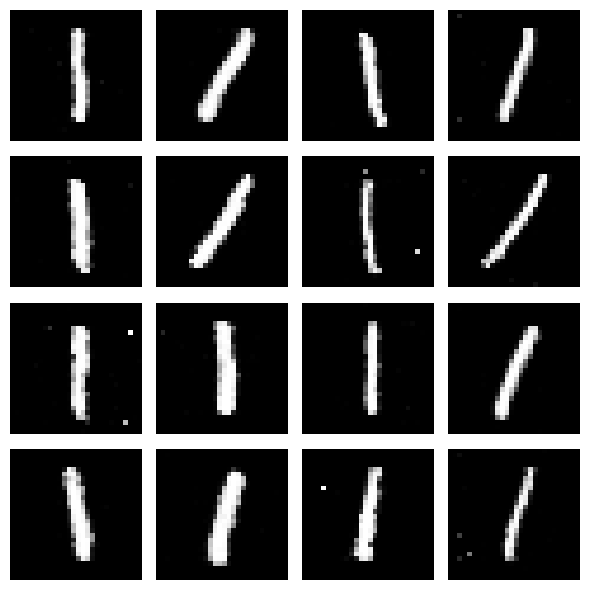



    ____________________ Step = 50 ____________________    ____________________ Step = 50 ____________________    ____________________ Step = 50 ____________________    ____________________ Step = 50 ____________________    ____________________ Step = 50 ____________________    ____________________ Step = 50 ____________________    ____________________ Step = 50 ____________________    ____________________ Step = 50 ____________________    ____________________ Step = 50 ____________________    ____________________ Step = 50 ____________________


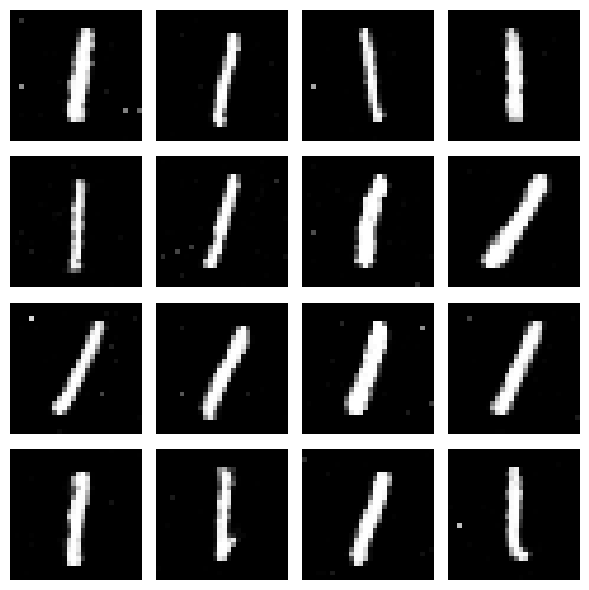



    ____________________ Step = 60 ____________________    ____________________ Step = 60 ____________________    ____________________ Step = 60 ____________________    ____________________ Step = 60 ____________________    ____________________ Step = 60 ____________________    ____________________ Step = 60 ____________________    ____________________ Step = 60 ____________________    ____________________ Step = 60 ____________________    ____________________ Step = 60 ____________________    ____________________ Step = 60 ____________________


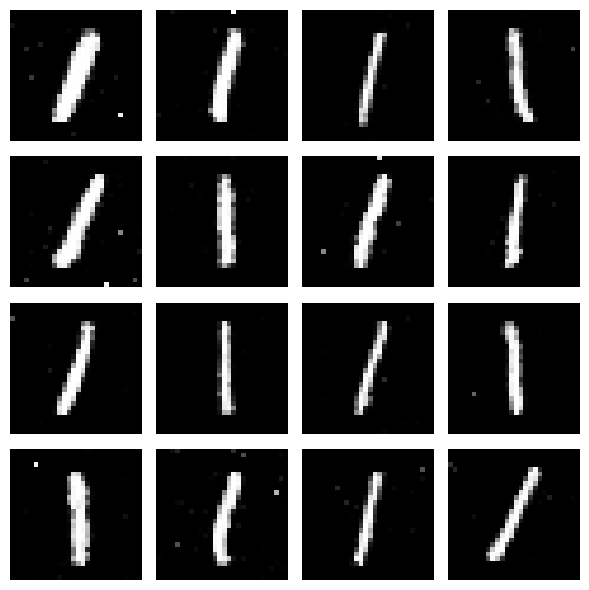



    ____________________ Step = 70 ____________________    ____________________ Step = 70 ____________________    ____________________ Step = 70 ____________________    ____________________ Step = 70 ____________________    ____________________ Step = 70 ____________________    ____________________ Step = 70 ____________________    ____________________ Step = 70 ____________________    ____________________ Step = 70 ____________________    ____________________ Step = 70 ____________________    ____________________ Step = 70 ____________________


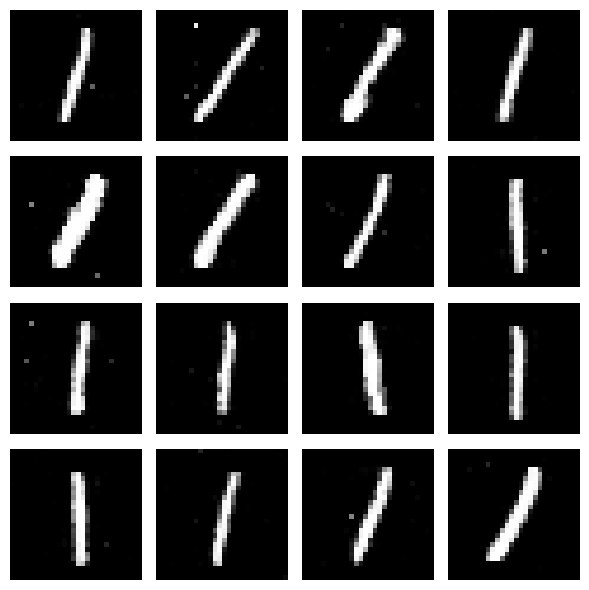



    ____________________ Step = 80 ____________________    ____________________ Step = 80 ____________________    ____________________ Step = 80 ____________________    ____________________ Step = 80 ____________________    ____________________ Step = 80 ____________________    ____________________ Step = 80 ____________________    ____________________ Step = 80 ____________________    ____________________ Step = 80 ____________________    ____________________ Step = 80 ____________________    ____________________ Step = 80 ____________________


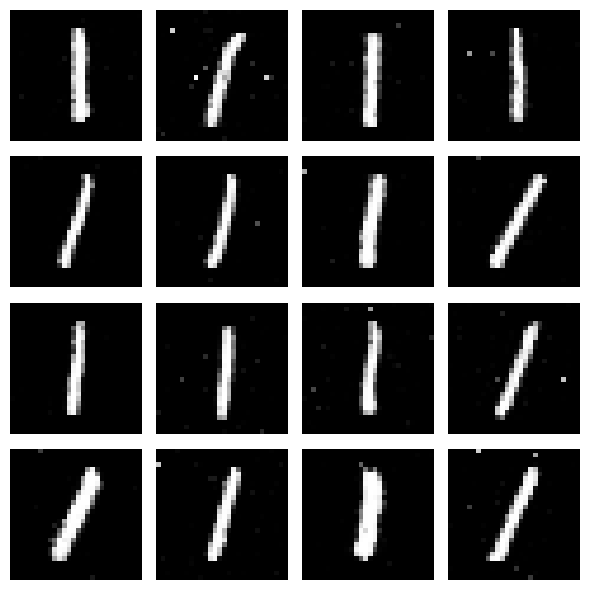



    ____________________ Step = 90 ____________________    ____________________ Step = 90 ____________________    ____________________ Step = 90 ____________________    ____________________ Step = 90 ____________________    ____________________ Step = 90 ____________________    ____________________ Step = 90 ____________________    ____________________ Step = 90 ____________________    ____________________ Step = 90 ____________________    ____________________ Step = 90 ____________________    ____________________ Step = 90 ____________________


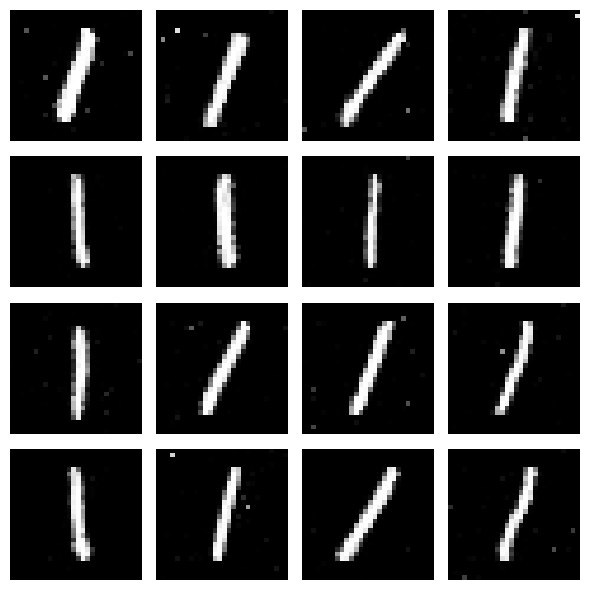

In [12]:
i = 0
for i in range(0, len(samples), 10):
    images = samples[i].data.cpu().numpy()
    print("    ____________________ Step = %d ____________________" % i*10)
    plt.figure(figsize = (6, 6))
    for i in range(16):
        plt.subplot(4, 4, i+1)
        image = images[i, :, :, :]
        image = np.reshape(image, [height, width])
        plt.imshow(image, cmap = 'gray')
        plt.axis('off')
    plt.tight_layout()
    plt.show()
    print("\n")

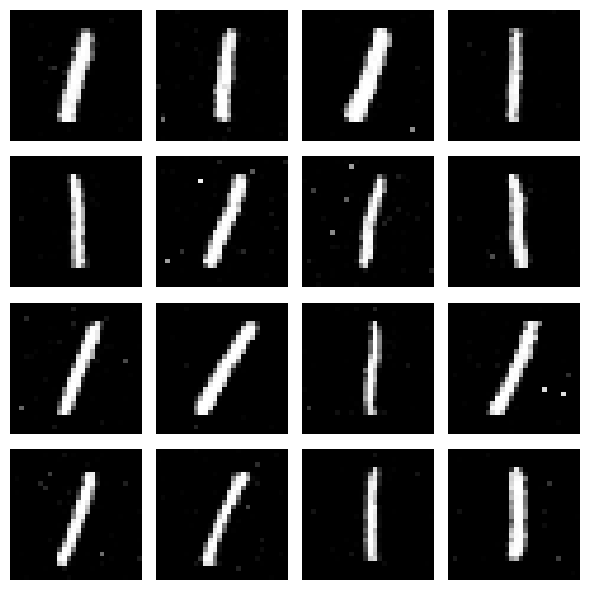

In [14]:
noise = torch.Tensor(np.random.normal(0, 1, (16, 100))).to(device)
gen_images = G(noise)
images = gen_images.data.cpu().numpy()
plt.figure(figsize = (6, 6))
for i in range(16):
    plt.subplot(4, 4, i+1)
    image = images[i, :, :, :]
    image = np.reshape(image, [height, width])
    plt.imshow(image, cmap = 'gray')
    plt.axis('off')
plt.tight_layout()
plt.show()